In [1]:
# el euch and rosenbaum: char fn of rough heston

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  

from scipy.special import gamma, digamma
from numpy import vectorize

In [2]:
# rough heston params

alpha = 0.75
l = 1
rho = 0.1
xi = 1
v0 = 0.04
theta = 0.2
vbar = 0.2

In [3]:
# params from original paper

l = 2
theta = 0.1
xi = 1
alpha = 0.6
rho = -0.8
v0 = 0.25
vbar = 0.2

In [4]:
# solver from El Euch, Rosenbaum

class CriticalValueError(Exception):

    def __init__(self, x, y, critical):
        self.x = x
        self.y = y
        self.critical = critical

 
class FRiccati:

    def __init__(self):
        self.delta = 0
        self.n = 0
        self.a = np.zeros(())
        self.b = np.zeros(())

    def _update_mat_a(self):

        self.a = np.zeros((self.n + 2, self.n + 2))

        for k in range(0, self.n + 1):
            for j in range(0, k + 2):
                if j == 0:
                    self.a[j, k + 1] = self.delta ** alpha / gamma(alpha + 2) * (
                            k ** (alpha + 1) - (k - alpha) * ((k + 1) ** alpha))
                elif j == k:
                    self.a[j, k + 1] = self.delta ** alpha / gamma(alpha + 2)
                else:
                    self.a[j, k + 1] = self.delta ** alpha / gamma(alpha + 2) * (
                            (k - j + 2) ** (alpha + 1) + (k - j) ** (alpha + 1) - 2 * (k - j + 1) ** (alpha + 1))

    def _update_mat_b(self):

        self.b = np.zeros((self.n + 2, self.n + 2))

        for k in range(0, self.n + 1):
            for j in range(0, k + 1):
                self.b[j, k + 1] = self.delta ** alpha / gamma(alpha + 1) * ((k - j + 1) ** alpha - (k - j) ** alpha)

    def _solve(self, p, t0, t1, n):

        @vectorize
        def _f(x):
            return (p ** 2 - p) / 2 + (p * rho * xi - l) * x + (xi ** 2) / 2 * (x ** 2)

        _delta = (t1 - t0) / n

        if _delta != self.delta or n != self.n:
            self.delta = _delta
            self.n = n

            # update matrices
            self._update_mat_a()
            self._update_mat_b()

        _h = np.array([0])
        _k = 1
        _t = np.linspace(t0, t1, self.n + 1)

        while _k < self.n + 1:
            hp = np.sum(self.b[0:_k, _k] * _f(_h[0:_k]))
            val = np.sum(self.a[0:_k, _k] * _f(_h[0:_k])) + self.a[_k, _k] * _f(hp)
            if val > 1e2:
                raise CriticalValueError(_t[0:_k], _h, _t[_k])
            _h = np.append(_h, val)
            _k += 1

        return _t, _h

    def critical_time(self, p, t0=0., t1=.5, n=1000):

        try:
            self._solve(p, t0, t1, n)
        except CriticalValueError as err:
            return err.critical

        return None

    def solve(self, p, t0=0., t1=1., n=1000):

        try:
            return self._solve(p, t0, t1, n)
        except CriticalValueError as err:
            return err.x, err.y

solver = FRiccati()

/Users/konstantinisstarovoitovs/projects/master/venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


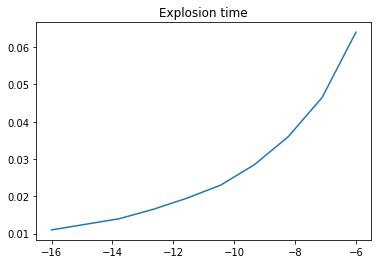

In [5]:
# explosion time for small moments

x = np.linspace(-16, -6, 10)
y = np.array([])

for v in x:
    y = np.append(y, solver.critical_time(v))

plt.title("Explosion time")
plt.plot(x, y)
plt.show()

# Exact explosion time

In [6]:
c1 = lambda s: s * (s - 1) / 2
c2 = lambda s: rho * xi * s - l
c3 = xi ** 2 / 2

d1 = lambda u: c1(u) * c3
d2 = lambda u: c2(u)

def explosion_time(u, n):
    
    assert c1(u) > 0
    assert c2(u) / 2 >= 0
    
    v = lambda n: gamma(alpha * n + 1) / gamma(alpha * n - alpha + 1)

    a = np.array([d1(u) / v(1)])

    for i in range(1, n):
        an = (d2(u) * a[-1] + np.sum(a[:-1] * np.flip(a[:-1]))) / v(i + 1)
        a = np.append(a, [an])

    # case A, left-hand side
    if u < l / xi / rho:
        return (a[-1] * (n ** (1 - alpha)) * (gamma(alpha) ** 2) / (alpha ** alpha) / gamma(2 * alpha)) ** (
                -1 / alpha / (n + 1))
    
    # case B, right-hand side, get lower bound
    else:
        return np.abs(a[-1]) ** (-1 / alpha / n)

In [7]:
vs = [u for u in np.arange(-100, 100, 0.01) if c1(u) > 0 and c2(u) >= 0]
mn = min(vs)
mx = max(vs)
print("Range with exact explosion time: {}, {}".format(mn, mx))

Range with exact explosion time: -100.0, -2.509999999950125


## Solution to the Fractional Riccati equations

In [ ]:
explosion_time

Range with exact explosion time: -100.0, -2.509999999950125


/Users/konstantinisstarovoitovs/projects/master/venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


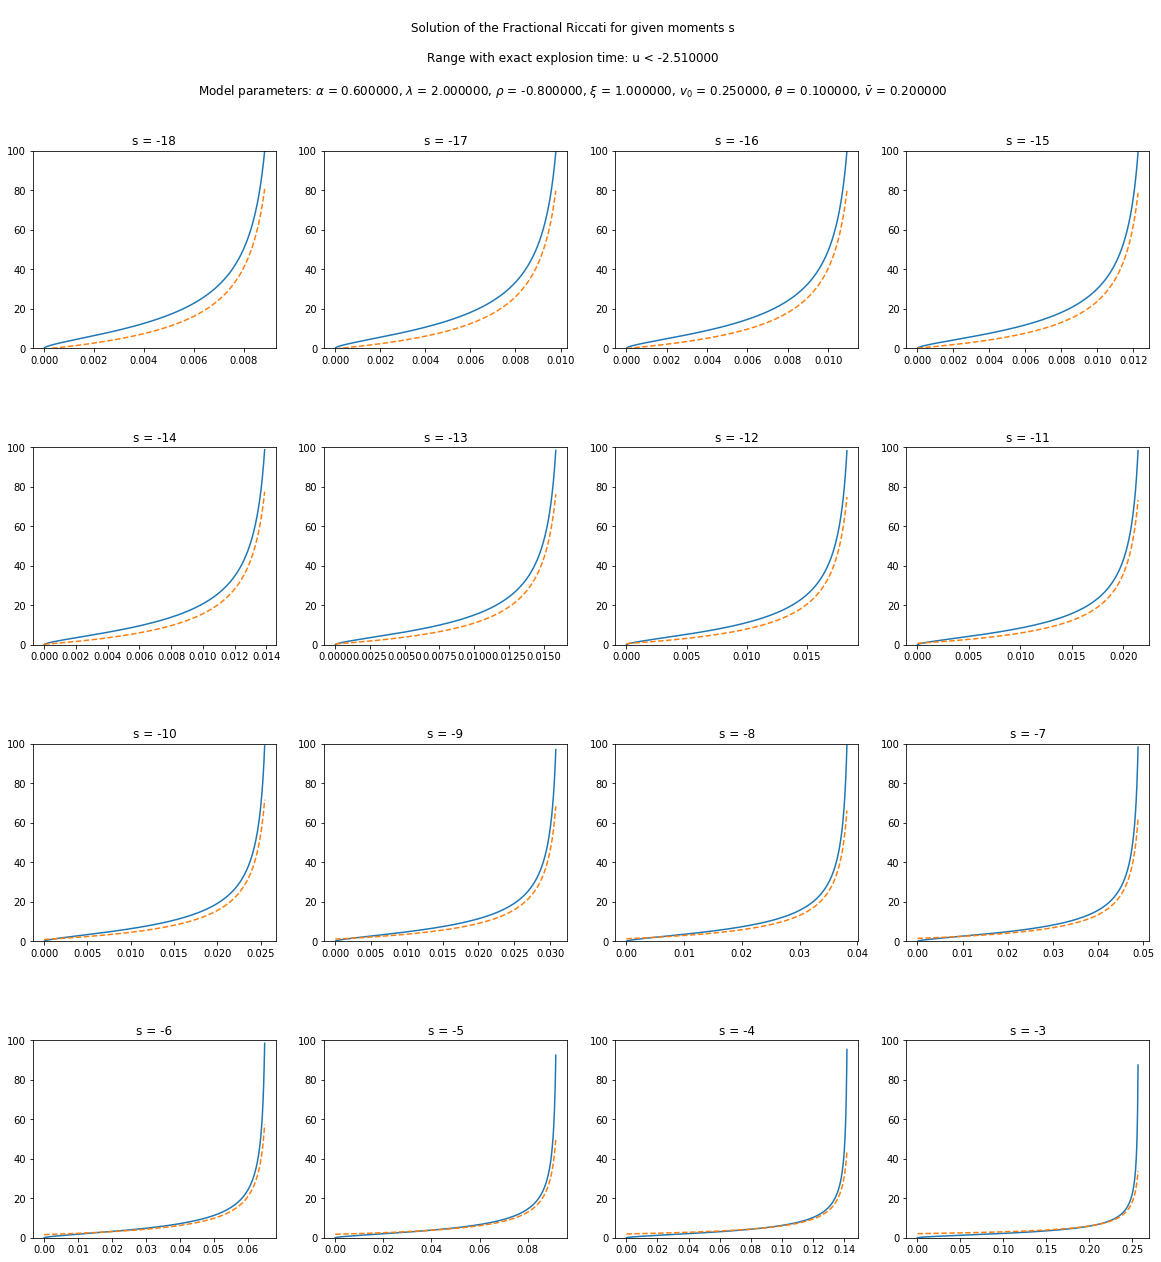

In [9]:
# parameters

l = 2
theta = 0.1
xi = 1
alpha = 0.6
rho = -0.8
v0 = 0.25
vbar = 0.2

# range with explosion time

vs = [u for u in np.arange(-100, 100, 0.01) if c1(u) > 0 and c2(u) >= 0]
mn = min(vs)
mx = max(vs)
print("Range with exact explosion time: {}, {}".format(mn, mx))

# plot

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
s = -18

title = """
Solution of the Fractional Riccati for given moments s\n
Range with exact explosion time: u < %f\n
Model parameters: $\\alpha$ = %f, $\\lambda$ = %f, $\\rho$ = %f, $\\xi$ = %f, $v_0$ = %f, $\\theta$ = %f, $\\bar v$ = %f
""" % (mx, alpha, l, rho, xi, v0, theta, vbar)

plt.suptitle(title)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

zs = np.array([])
cs = np.array([])

for row in ax:
    for col in row:
        
        # obtain constants
        theta0 = 2 * gamma(2 * alpha) / gamma(alpha) / xi ** 2
        theta1 = digamma(alpha) / gamma(alpha) * (rho * xi * s - l) / (gamma(alpha) / gamma(2 * alpha) - xi ** 2)

        T = explosion_time(s, 100)
        x, y1 = solver.solve(s, t1=T, n=1000)
        y2 = theta0 * (T - x) ** (- alpha) + theta1

        # plot both
        col.title.set_text("s = {}".format(s))
        col.set_ylim((0, 100))
        col.plot(x, y1)
        col.plot(x, y2, linestyle='--')
                
        s += 1
       
        # criticals
        cs = np.append(cs, x[-1])

Range with exact explosion time: 10.000000000056275, 99.99000000010233


/Users/konstantinisstarovoitovs/projects/master/venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


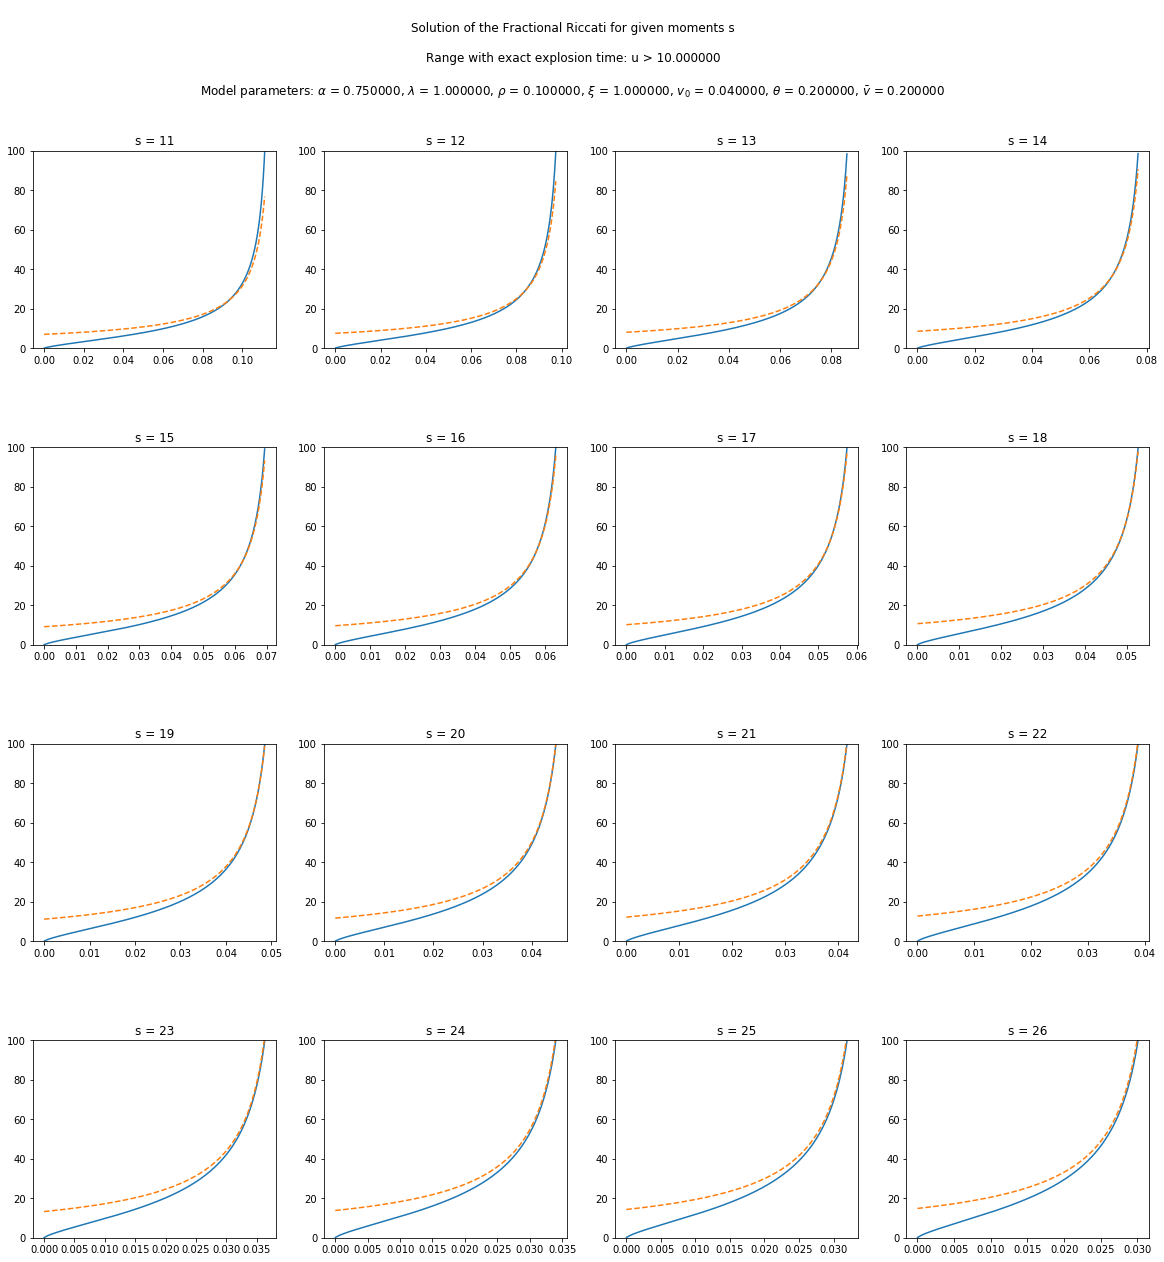

In [10]:
# parameters

alpha = 0.75
l = 1
rho = 0.1
xi = 1
v0 = 0.04
theta = 0.2
vbar = 0.2

# range with explosion time

vs = [u for u in np.arange(-100, 100, 0.01) if c1(u) > 0 and c2(u) >= 0]
mn = min(vs)
mx = max(vs)
print("Range with exact explosion time: {}, {}".format(mn, mx))

# plot

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
s = 11

title = """
Solution of the Fractional Riccati for given moments s\n
Range with exact explosion time: u > %f\n
Model parameters: $\\alpha$ = %f, $\\lambda$ = %f, $\\rho$ = %f, $\\xi$ = %f, $v_0$ = %f, $\\theta$ = %f, $\\bar v$ = %f
""" % (mn, alpha, l, rho, xi, v0, theta, vbar)

plt.suptitle(title)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)

zs = np.array([])
cs = np.array([])

for row in ax:
    for col in row:
        
        # obtain constants
        theta0 = 2 * gamma(2 * alpha) / gamma(alpha) / xi ** 2
        theta1 = digamma(alpha) / gamma(alpha) * (rho * xi * s - l) / (gamma(alpha) / gamma(2 * alpha) - xi ** 2)

        T = explosion_time(s, 100)
        x, y1 = solver.solve(s, t1=T, n=1000)
        y2 = theta0 * (T - x) ** (- alpha) + theta1

        # plot both
        col.title.set_text("s = {}".format(s))
        col.set_ylim((0, 100))
        col.plot(x, y1)
        col.plot(x, y2, linestyle='--')
                
        s += 1
       
        # criticals
        cs = np.append(cs, x[-1])

# Critical time for given moments

ValueError: x and y must have same first dimension, but have shapes (8,) and (16,)

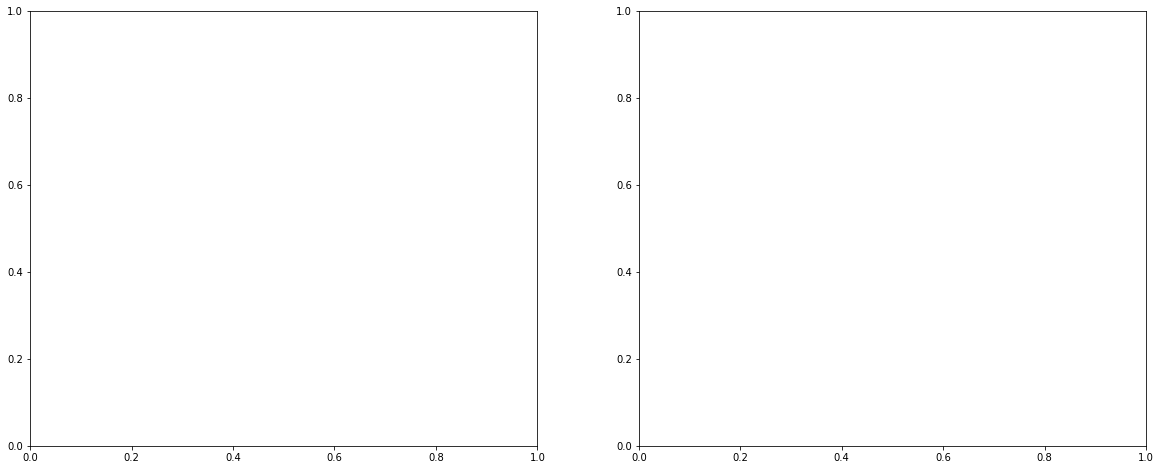

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# critical values
x = np.linspace(4, 7.5, 8)

ax1.plot(x, cs)
ax1.set_title("Critical time for given moments s")
ax1.plot(x[2], cs[2], 'o')

ax2.plot(cs, x)
ax2.set_title("Critical moments for given time")
ax2.plot(cs[2], x[2], 'o')

plt.show()

# Solution $\Lambda(p)$

In [ ]:
s = 5

x, y = solver.solve(s)

# from the equation (21) we calculate Lambda(p, T)
z1 = np.cumsum(s ** 2 / 2 + s * xi * rho * y + xi ** 2 * y ** 2 / 2) / (x[1] - x[0])

# using scaling property (23) we calculate asymptotic Lambda(p)
# todo: we actually have solve for t, not p and fixed time T

plt.title("Lambda(s, T) for s = 5")
plt.plot(x, z1)
plt.show()

# Critical slope

In [ ]:
# explosion time for large moments and critical slope

def critical_slope(s, plot=False):

    _delta = .1
    
    x = np.linspace(s - _delta, s + _delta, 3)
    y = vectorize(solver.critical_time)(x)

    if plot:
        plt.title("Explosion time")
        plt.plot(x, y)
        plt.show()

    z = np.gradient(y) / _delta

    # critical slope
    return -z[1]

sigma = critical_slope(5, plot=True)
print(sigma)

In [ ]:
# check asymptotic, use log-regression to find out the constant and calculate beta of the approx saddle point

x, y = solver.solve(5)

# critical time
T = x[-1]

# log-log regress to find constant
_, C = np.polyfit(np.log(x[-1] - x[-10:-1]), np.log(y[-10:-1]), 1)
# assert np.abs(alpha - _) < tol

# beta for the approximate saddle point
C_alpha = C * v0 * gamma(1 - alpha) / gamma(2 - 2 * alpha)
beta = (- C_alpha * (1 - 2 * alpha) * sigma ** (1 - 2 * alpha)) ** (1 / 2 / alpha)

print(beta)

In [ ]:
# calculate log-mgf

def logmgf(y, x):

    def fintegrate(y, x, alpha):
        integ = [0.]
        _delta = x[1] - x[0]
        for k in range(1, len(x)):
            _t = x[k]
            _h = (_t - np.linspace(0, _t, k) + _delta) ** (alpha - 1) / gamma(alpha)
            integ.append(np.sum(_h * y[0:k]) * _delta)

        return np.array(integ)

    i1alpha = fintegrate(y, x, alpha)
    i1 = fintegrate(y, x, 1)

    logmgf = v0 * i1alpha + l * theta * i1

    return logmgf
        
plt.plot(x, logmgf(y, x))
plt.show()

In [ ]:
k = np.linspace(np.log(1e3), np.log(1e13), 10)

z = 5 - beta * k ** (-1 / 2 / alpha)
s = np.vectorize(critical_slope)(z)

plt.plot(k, 2 / z / (z - 1) / s, marker="o")

In [ ]:
k = np.linspace(np.log(1e3), np.log(1e13), 10)

z = 5 - beta * k ** (-1 / 2 / alpha)
grads = []

for v in z:
    x, y = solver.solve(v)
    _delta = x[1] - x[0]
    grads.append((np.gradient(logmgf(y, x)) / _delta)[403])

plt.plot(k, 2 / z / (z - 1) * grads, marker="o")
plt.plot(k, 0.1 * k)
plt.show()

In [ ]:
# todo: critical moment as a function of time (and vice versa), is it invertible? conjecture: power law